In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import math
import datetime
import tensorflow as tf
import tushare as ts
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [2]:
def split_windows(data,size):
    X=[]
    Y=[]
    for i in range(len(data)-size):
        X.append(data[i:i+size,:])
        Y.append(data[i+size,-1])
    return np.array(X),np.array(Y)

In [3]:
df=pd.read_csv('./data_NVDA.csv',usecols=['Open','High','Close','Low','Volume'])
all_data=df.values
train_len=600
train_data=all_data[:train_len,:]
test_data=all_data[train_len:,:]

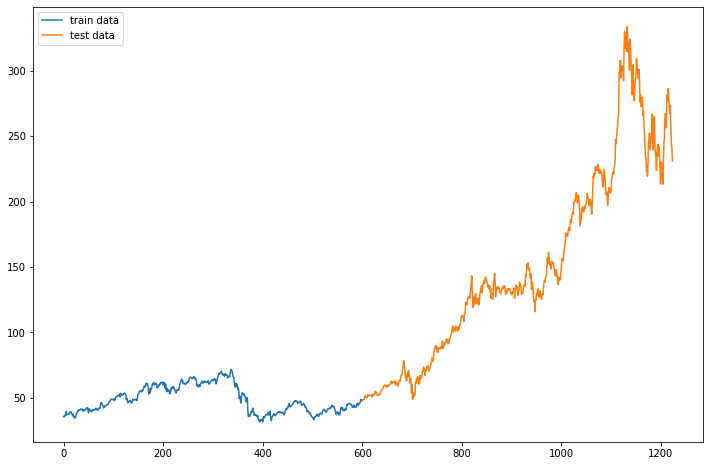

In [4]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(train_data.shape[0]),train_data[:,2],label='train data')
plt.plot(np.arange(train_data.shape[0],train_data.shape[0]+test_data.shape[0]),test_data[:,2],label='test data')
plt.legend()
plt.show()

In [5]:
scaler=MinMaxScaler()
scaled_train_data=scaler.fit_transform(train_data)
scaled_test_data=scaler.transform(test_data)

In [6]:
window_size=10
train_X,train_Y=split_windows(scaled_train_data,size=window_size)
test_X,test_Y=split_windows(scaled_test_data,size=window_size)
print('train shape',train_X.shape,train_Y.shape)
print('test shape',test_X.shape,test_Y.shape)

train shape (590, 10, 5) (590,)
test shape (614, 10, 5) (614,)


In [7]:
window_size=10
fea_num=5
model=keras.models.Sequential([
    keras.layers.Input((window_size,fea_num)),
    keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,padding="same",activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2,strides=1,padding="same"),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(filters=32,kernel_size=3,strides=1,padding="same",activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2,strides=1,padding="same"),
    keras.layers.Flatten(), 
    keras.layers.Dense(1)
])
model.compile(loss='mse',optimizer='adam',metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 64)            1024      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [8]:
model.fit(x=train_X,y=train_Y,epochs=50)

Epoch 1/50
19/19 [==============================] - 1s 4ms/step - loss: 0.0136 - mse: 0.0136
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0072 - mse: 0.0072
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0052 - mse: 0.0052
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0048 - mse: 0.0048
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0044 - mse: 0.0044
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0041 - mse: 0.0041
Epoch 8/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0043 - mse: 0.0043
Epoch 9/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0040 - mse: 0.0040
Epoch 10/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0039 - mse: 0.0039
Epoch 11/50
19/19 [==============================] - 0s 4ms/step - lo

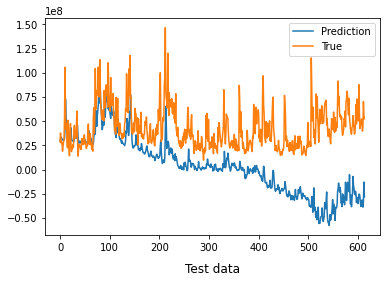

In [9]:
prediction=model.predict(test_X)
scaled_prediction=prediction*(scaler.data_max_[-1]-scaler.data_min_[-1])+scaler.data_min_[-1]
scaled_true=test_Y*(scaler.data_max_[-1]-scaler.data_min_[-1])+scaler.data_min_[-1]
plt.plot(range(len(scaled_prediction)),scaled_prediction,label='Prediction')
plt.plot(range(len(scaled_true)),scaled_true,label='True')
plt.title('Test data',y=-0.2)
plt.legend()
plt.show()

In [10]:
from sklearn import metrics

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print("MSE",metrics.mean_squared_error(test_Y, prediction))
print("RMSE",np.sqrt(metrics.mean_squared_error(test_Y, prediction)))
print("MAE",metrics.mean_absolute_error(test_Y, prediction))
print("MAPE",mape(test_Y, prediction))

MSE 0.01983037244330629
RMSE 0.14082035521651792
MAE 0.11390675681839299
MAPE 613.3508722046771
